# Домашнее задание №4.
Формулируем задачу в терминах ML

**Суть проекта:** cоздать самообучающуюся систему для выявления аномальных транзакций с применением графовых нейронных сетей в сети блокчейн. Основная задача — повысить точность и оперативность обнаружения финансового мошенничества

**Работа основана на датасете Elliptic++:** 

> https://github.com/git-disl/EllipticPlusPlus

> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics. In Proceedings of the 29th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD ’23), August 6–10, 2023, Long Beach, CA, USA. ACM, New York, NY, USA, 12 pages. https://doi.org/10.1145/3580305.3599803

**Описание данных:** 

**Транзакции (transactions):**

- txs_features.csv – 203 769 строк, по 183 исходных признака (включая “временной шаг”, 93 локальных признака и 72 агрегированных) плюс 17 дополнительных, рассчитанных в расширении Elliptic++ (например, суммарный BTC_in/BTC_out, число входящих/исходящих транзакций, число адресов, размер транзакции, комиссии) 

- txs_classes.csv – метка каждого узла-транзакции: 1 = illicit, 2 = licit, 3 = unknown

- txs_edgelist.csv – ориентированные рёбра «транзакция → транзакция», задающие поток средств

**Акторы (wallet addresses):**

- wallets_features.csv – 822 942 адреса, по 56 признаков: статистика отправленных/полученных BTC, комиссии, временные интервалы между операциями, число взаимодействий с другими адресами и т. д.

- wallets_classes.csv – метка каждого адреса (illicit/licit/unknown) на основе его связей с помеченными транзакциями

- AddrAddr_edgelist.csv – рёбра «адрес → адрес» через общие транзакции

- AddrTx_edgelist.csv – рёбра «адрес → транзакция»

- TxAddr_edgelist.csv – рёбра «транзакция → адрес»

**Этапы выполнения задания:**

1. Загрузку и очистка данных 

2. Анализ данных 

3. Выбор 1-2 простых модели и 1 усложнённой (оптимизация гиперпараметров/AutoML/мультимодальность) 

4. Оценка метрик качества (не менее 2), оценка совокупной метрики качества, анализ результатов 

##  1. Загрузим библиотеки

In [1]:
import os
import pandas as pd
import torch
import arviz as az
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display, Markdown

##  2. Загрузка и очистка данных

### 2.1 Загрузка и очистка данных транзакций

In [2]:
df_features = pd.read_csv('data/elliptic-bitcoin/transactions/txs_features.csv') # 203 769 строк, по 183 исходных признака (включая “временной шаг”, 93 локальных признака и 72 агрегированных) плюс 17 дополнительных, рассчитанных в расширении Elliptic++ (например, суммарный BTC_in/BTC_out, число входящих/исходящих транзакций, число адресов, размер транзакции, комиссии)
df_classes = pd.read_csv('data/elliptic-bitcoin/transactions/txs_classes.csv') # метка каждого узла-транзакции: 1 = illicit, 2 = licit, 3 = unknown.
df_edgelist = pd.read_csv('data/elliptic-bitcoin/transactions/txs_edgelist.csv') # ориентированные рёбра «транзакция → транзакция», задающие поток средств.

In [3]:
display(Markdown("Транзакции характеристики:"))
display(df_features.head(1))

display(Markdown("Транзакции связи:"))
display(df_edgelist.head(1))

display(Markdown("Транзакции классы:"))
display(df_classes.head(1))


Транзакции характеристики:

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total
0,3321,1,-0.169615,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.160199,...,0.534072,0.534072,0.534072,0.534072,0.534072,0.166899,0.367074,0.266986,0.266986,0.533972


Транзакции связи:

,txId1,txId2
0,230425980,5530458


Транзакции классы:

,txId,class
0,3321,3


In [4]:
print(f"Транзакции характеристики: {df_features.shape}")
print(f"Транзакции классы: {df_classes.shape}")
print(f"Транзакции связи: {df_edgelist.shape}")

print('Количество пропущенных значений в транзакциях:', df_features.isna().values.sum(), round(df_features.isna().values.sum() / len(df_features) * 100, 2), '%')
print('Количество пропущенных значений в классах транзакций:', df_classes.isna().values.sum(), round(df_classes.isna().values.sum() / len(df_classes) * 100, 2), '%')
print('Количество пропущенных значений в рёбрах транзакций:', df_edgelist.isna().values.sum(), round(df_edgelist.isna().values.sum() / len(df_edgelist) * 100, 2), '%')  

Транзакции характеристики: (203769, 184)
Транзакции классы: (203769, 2)
Транзакции связи: (234355, 2)
Количество пропущенных значений в транзакциях: 16405 8.05 %
Количество пропущенных значений в классах транзакций: 0 0.0 %
Количество пропущенных значений в рёбрах транзакций: 0 0.0 %


In [5]:
missing_tx = df_features.isnull().sum()
missing_tx = missing_tx[missing_tx > 0]
print(f"Общее количество пропущенных значений в транзакциях: {df_features.isna().sum().sum()}")
print(f"Количество признаков с пропущенными значениями: {len(missing_tx)}")
if len(missing_tx) > 0:
    print("\nПризнаки с пропущенными значениями:")
    print(missing_tx)

Общее количество пропущенных значений в транзакциях: 16405
Количество признаков с пропущенными значениями: 17

Признаки с пропущенными значениями:
in_txs_degree           965
out_txs_degree          965
total_BTC               965
fees                    965
size                    965
num_input_addresses     965
num_output_addresses    965
in_BTC_min              965
in_BTC_max              965
in_BTC_mean             965
in_BTC_median           965
in_BTC_total            965
out_BTC_min             965
out_BTC_max             965
out_BTC_mean            965
out_BTC_median          965
out_BTC_total           965
dtype: int64


Как можно заметить пропущенные значения в колонках с характеристиками транзакций, что говорит о том, что вероятно не удалось спарсить эти данные из сети блокчейн, посмотрим далее можно ли это исправить заполнив их

### 2.2 Загрузка и очистка данных кошельков

In [6]:
df_AddrTx_edgelist = pd.read_csv('data/elliptic-bitcoin/actors/AddrTx_edgelist.csv') # рёбра «адрес → транзакция»
df_TxAddr_edgelist = pd.read_csv('data/elliptic-bitcoin/actors/TxAddr_edgelist.csv') # рёбра «транзакция → адрес»
df_wallets_classes = pd.read_csv('data/elliptic-bitcoin/actors/wallets_classes.csv') # метка каждого адреса (illicit/licit/unknown) на основе его связей с помеченными транзакциями.
df_wallets_features = pd.read_csv('data/elliptic-bitcoin/actors/wallets_features.csv') # 822 942 адреса, по 56 признаков: статистика отправленных/полученных BTC, комиссии, временные интервалы между операциями, число взаимодействий с другими адресами и т. д. 

In [7]:
display(Markdown("Связи адрес-транзакция:"))
display(df_AddrTx_edgelist.head(1))

display(Markdown("Связи транзакция-адрес:"))
display(df_TxAddr_edgelist.head(1))

display(Markdown("Кошельки (классы):"))
display(df_wallets_classes.head(1))

display(Markdown("Кошельки (характеристики):"))
display(df_wallets_features.head(1))


Связи адрес-транзакция:

,input_address,txId
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,230325127


Связи транзакция-адрес:

,txId,output_address
0,230325127,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH


Кошельки (классы):

,address,class
0,111112TykSw72ztDN2WJger4cynzWYC5w,2


Кошельки (характеристики):

,address,Time step,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,111112TykSw72ztDN2WJger4cynzWYC5w,25,0.0,1.0,439586.0,439586.0,0.0,1.0,0.0,439586.0,...,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,1.0,1.0


In [8]:
print(f"Связи адрес-транзакция: {df_AddrTx_edgelist.shape}")
print(f"Связи транзакция-адрес: {df_TxAddr_edgelist.shape}")
print(f"Кошельки (классы): {df_wallets_classes.shape}")
print(f"Кошельки (характеристики): {df_wallets_features.shape}")

print('Количество пропущенных значений в рёбрах «адрес → транзакция»:', df_AddrTx_edgelist.isna().values.sum(), round(df_AddrTx_edgelist.isna().values.sum() / len(df_AddrTx_edgelist) * 100, 2), '%')
print('Количество пропущенных значений в рёбрах «транзакция → адрес»:', df_TxAddr_edgelist.isna().values.sum(), round(df_TxAddr_edgelist.isna().values.sum() / len(df_TxAddr_edgelist) * 100, 2), '%')  
print('Количество пропущенных значений в классах транзакций:', df_wallets_classes.isna().values.sum(), round(df_wallets_classes.isna().values.sum() / len(df_wallets_classes) * 100, 2), '%')  
print('Количество пропущенных значений в кошельках:', df_wallets_features.isna().values.sum(), round(df_wallets_features.isna().values.sum() / len(df_wallets_features) * 100, 2), '%')  

Связи адрес-транзакция: (477117, 2)
Связи транзакция-адрес: (837124, 2)
Кошельки (классы): (822942, 2)
Кошельки (характеристики): (1268260, 57)
Количество пропущенных значений в рёбрах «адрес → транзакция»: 0 0.0 %
Количество пропущенных значений в рёбрах «транзакция → адрес»: 0 0.0 %
Количество пропущенных значений в классах транзакций: 0 0.0 %
Количество пропущенных значений в кошельках: 0 0.0 %


### 2.3 Преобразую данные в единые датасеты (по возможности) для удобства и переименую классы

In [12]:
# Объединяю транзакции и классы
df_transactions = df_features.merge(df_classes, on='txId')

# Объединяю кошельки и классы
df_wallets = df_wallets_features.merge(df_wallets_classes, on='address')

# Переименовываю классы
label_map = {1: 'illicit', 2: 'licit', 3: 'unknown'}
df_transactions['class_map'] = df_transactions['class'].map(label_map)
df_wallets['class_map'] = df_wallets['class'].map(label_map)


## 3. Анализ данных

### 3.1 Анализ транзакций. Табличное представление

In [13]:
numeric_cols = df_transactions.select_dtypes(include='number').columns
local_agg_features = [col for col in numeric_cols if col.startswith('Local') or col.startswith('Aggregate')]
df_transactions[local_agg_features]

,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,-0.166062,-0.049707,...,-0.577099,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
1,-0.137586,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.127429,-0.133751,-0.049707,...,-0.562153,-0.600999,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,-0.170103,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160699,-0.166555,-0.049707,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,-0.118555,0.300047,...,-0.569626,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,5.202107,-0.210553,-1.756361,-0.121970,260.090707,-0.113002,-0.061584,5.335864,5.252974,-0.049707,...,1.258630,0.982479,0.118347,0.091066,-0.098889,0.854508,-0.066727,-0.150067,-0.080760,-0.070977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,-0.165622,-0.139563,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156113,-0.162033,-0.049707,...,-0.509843,-0.556847,1.461330,1.461369,0.018279,0.181652,0.519580,0.505505,1.519700,1.521399
203765,-0.167040,-0.139563,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.157564,-0.163463,-0.049707,...,-0.554681,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203766,-0.167040,-0.139563,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.157564,-0.163463,-0.049707,...,-0.412695,-0.424391,-0.979074,-0.978556,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984
203767,-0.172212,-0.139573,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.162856,-0.168681,-0.049707,...,-0.569626,-0.506387,1.461330,1.461369,0.018279,0.143203,0.426618,0.419358,1.519700,1.521399


In [14]:
df_AddrTx_edgelist[df_AddrTx_edgelist['txId'] == 3321]

,input_address,txId
19941,18TnVVsNqViRGTNzCjk5dnW4VNxpehywXB,3321


In [21]:
df_edgelist[df_edgelist['txId1'] == 158303968]

,txId1,txId2
232274,158303968,124606491
233057,158303968,158303966


In [16]:
df_transactions[df_transactions['txId'] == 	196542151]

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class,class_map
2739,196542151,1,-0.168603,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.159164,...,0.694477,0.694477,0.694477,0.160304,0.534072,0.347188,0.347188,0.694377,3,unknown


In [22]:
df_transactions[df_transactions['txId'] == 124606491]

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class,class_map
200514,124606491,49,-0.154692,0.578894,1.573595,0.553368,0.234026,0.474034,0.242712,-0.162237,...,0.290289,0.25624,2.902893,0.005828,1.167017,0.18124,0.063846,2.899843,2,licit


In [23]:
# df_AddrTx_edgelist, df_TxAddr_edgelist, df_edgelist объедини в один датафрейм для удобства 
# фича прикольная что у одинаковых транзакций встречаются local и agg одинаковые и посмотреть на пропуски что с ними делать
# knn бы проехаться и учитывать что транзы связаны и чудно будет

In [ ]:
edgelist = df_edgelist

df_AddrTx_edgelist, 

In [90]:
merged = edgelist.merge(df_transactions, on='txId', how='left')

# 3. Оставляем только числовые признаки из df_transactions (кроме 'txId')
numeric_feats = (
    df_transactions
    .select_dtypes(include='number')
    .columns
    .drop('txId')
    .tolist()
)

# 4. Группируем по паре wallet1→wallet2
grouped = merged.groupby(['txId1','txId2'])

# 5. Для каждого признака считаем, в какой доле групп он был константой
constancy = {
    feat: grouped[feat].nunique().eq(1).mean()
    for feat in numeric_feats
}

# 6. Складываем в DataFrame и сортируем
constancy_df = (
    pd.DataFrame.from_dict(constancy, orient='index', columns=['constancy_rate'])
      .sort_values('constancy_rate', ascending=False)
)

KeyError: 'txId1'

In [86]:
merged

,txId1,txId2,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,...,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class,class_map
0,230425980,5530458,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,...,0.237665,0.237665,0.237665,0.022749,0.214816,0.118783,0.118783,0.237565,3,unknown
1,232022460,232438397,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,...,0.317164,0.005161,53.283544,53.275144,53.275144,53.275144,53.275144,53.275144,2,licit
2,230460314,230459870,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,...,8.989403,1.679303,179.788069,0.000100,35.650000,8.561313,0.150000,179.787569,3,unknown
3,230333930,230595899,230595899,1,-0.171755,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,...,0.097335,0.097335,0.194670,0.014470,0.180100,0.097285,0.097285,0.194570,3,unknown
4,232013274,232029206,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,...,0.436568,0.093377,26.630669,26.627619,26.627619,26.627619,26.627619,26.627619,2,licit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234350,158365409,157930723,157930723,49,-0.140504,6.290312,2.128587,9.707944,-0.043875,10.537502,...,0.039199,0.031288,5.174222,0.010000,5.139108,2.574554,2.574554,5.149108,2,licit
234351,188708874,188708879,188708879,49,-0.172934,-0.165264,1.018602,-0.121970,-0.043875,-0.113002,...,0.007950,0.007950,0.007950,0.002078,0.005697,0.003888,0.003888,0.007775,3,unknown
234352,157659064,157659046,157659046,49,-0.170967,0.048298,-1.201369,2.129156,-0.043875,2.235141,...,0.010338,0.004483,0.320490,0.009000,0.310490,0.159745,0.159745,0.319490,3,unknown
234353,87414554,106877725,106877725,49,-0.022537,7.494825,1.573595,7.381781,1.166977,8.273222,...,0.236449,0.010000,23.881328,0.004000,2.999000,0.378596,0.140000,23.851561,2,licit


In [85]:
constancy_df

,constancy_rate
Time step,1.000000
Aggregate_feature_22,1.000000
Aggregate_feature_14,1.000000
Aggregate_feature_15,1.000000
Aggregate_feature_16,1.000000
...,...
size,0.995871
fees,0.995871
total_BTC,0.995871
out_txs_degree,0.995871


In [79]:
# Выбор строк
row1 = df_transactions[df_transactions['txId'] == 196542151].squeeze()
row2 = df_transactions[df_transactions['txId'] == 3321].squeeze()

# Сравнение по столбцам
comparison = row1 == row2

# Результаты
matching_cols = comparison[comparison].index.tolist()
non_matching_cols = comparison[~comparison].index.tolist()

print("✅ Совпадают:", matching_cols)
print("❌ Не совпадают:", non_matching_cols)


✅ Совпадают: ['Time step', 'Local_feature_2', 'Local_feature_3', 'Local_feature_4', 'Local_feature_5', 'Local_feature_6', 'Local_feature_7', 'Local_feature_10', 'Local_feature_12', 'Local_feature_13', 'Local_feature_14', 'Local_feature_15', 'Local_feature_22', 'Local_feature_23', 'Local_feature_24', 'Local_feature_25', 'Local_feature_26', 'Local_feature_27', 'Local_feature_28', 'Local_feature_29', 'Local_feature_30', 'Local_feature_31', 'Local_feature_32', 'Local_feature_33', 'Local_feature_34', 'Local_feature_35', 'Local_feature_36', 'Local_feature_37', 'Local_feature_38', 'Local_feature_39', 'Local_feature_40', 'Local_feature_41', 'Local_feature_42', 'Local_feature_43', 'Local_feature_44', 'Local_feature_45', 'Local_feature_46', 'Local_feature_47', 'Local_feature_48', 'Local_feature_49', 'Local_feature_50', 'Local_feature_51', 'Local_feature_52', 'Local_feature_53', 'Local_feature_54', 'Local_feature_55', 'Local_feature_56', 'Local_feature_57', 'Local_feature_70', 'Local_feature_71',

In [82]:
df_transactions['num_output_addresses']

0             2.0
1             2.0
2             2.0
3             2.0
4         13107.0
           ...   
203764        NaN
203765        NaN
203766        NaN
203767        NaN
203768        NaN
Name: num_output_addresses, Length: 203769, dtype: float64

In [77]:
df_transactions[df_transactions['txId'] == 3321]

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class,class_map
0,3321,1,-0.169615,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.160199,...,0.534072,0.534072,0.534072,0.166899,0.367074,0.266986,0.266986,0.533972,3,unknown


In [67]:
df_wallets

,address,Time step,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median,class,class_map
0,111112TykSw72ztDN2WJger4cynzWYC5w,25,0.0,1.0,439586.0,439586.0,0.0,1.0,0.0,439586.0,...,0.000000,0.0,0.0,24.0,1.0,1.0,1.0,1.0,2,licit
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,25,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0,3,unknown
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,29,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0,3,unknown
3,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0,3,unknown
4,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0,3,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268255,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,31,1.0,1.0,451684.0,451685.0,1.0,2.0,451685.0,451684.0,...,0.000000,0.0,0.0,3.0,1.0,1.0,1.0,1.0,3,unknown
1268256,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,44,0.0,1.0,477895.0,477895.0,0.0,1.0,0.0,477895.0,...,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3,unknown
1268257,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,9,0.0,1.0,407342.0,407342.0,0.0,1.0,0.0,407342.0,...,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3,unknown
1268258,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,3,0.0,1.0,395235.0,395235.0,0.0,1.0,0.0,395235.0,...,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3,unknown


В данных присутствуют уже готовые фичи для обучения моделей, которые предоставляла компания Elliptic для проведения соревнований, но компания не раскрыла их смысл и суть, что может не позволить использовать эти данные в продакшене, так как непонятно каким образом данные фичи были получены. Вероятно все же они были получены на основе характеристик, которые представлены в датасете, как например, in_BTC_min, in_BTC_max, in_BTC_mean	in_BTC_median и так далее. Поэтому попробую восстановить пропущенные значения в этих колонках на основе фичей, после чего удалю их

In [ ]:

numeric_cols = df_transactions.select_dtypes(include='number').columns
local_agg_features = [col for col in numeric_cols if col.startswith('Local') or col.startswith('Aggregate')]
other_features = [col for col in numeric_cols if col not in local_agg_features]

corr_matrix = df_transactions[numeric_cols].corr()

corr_subset = corr_matrix.loc[local_agg_features, other_features].abs()

# 5. Топ скоррелированные признаки
max_corrs = corr_subset.max(axis=1).sort_values(ascending=False)
top_correlated = max_corrs.head(10)

print(top_correlated)


Local_feature_4     1.0
Local_feature_16    1.0
Local_feature_9     1.0
Local_feature_1     1.0
Local_feature_2     1.0
Local_feature_8     1.0
Local_feature_17    1.0
Local_feature_11    1.0
Local_feature_19    1.0
Local_feature_5     1.0
dtype: float64


In [63]:
corr_subset

,txId,Time step,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class
Local_feature_1,0.013186,0.026173,0.012566,0.061621,1.000000,0.022829,0.022207,0.005925,0.029837,0.977684,0.995457,0.983210,0.981617,1.000000,0.184440,0.996121,0.902009,0.818778,1.000000,0.032615
Local_feature_2,0.096023,0.155124,0.377081,0.143047,0.022829,1.000000,0.494735,0.537971,0.151859,0.001055,0.010486,0.001808,0.001462,0.022853,0.107603,0.018583,0.011532,0.010177,0.022829,0.073979
Local_feature_3,0.169648,0.573155,0.068966,0.036610,0.050935,0.201306,0.099663,0.098462,0.032204,0.058248,0.053982,0.057703,0.058081,0.050930,0.005468,0.053234,0.086456,0.093657,0.050935,0.080407
Local_feature_4,0.006038,0.001716,0.508036,0.015451,0.005925,0.537971,0.768092,1.000000,0.008106,0.019916,0.011035,0.019500,0.019835,0.005938,0.110938,0.003309,0.011270,0.011181,0.005925,0.082113
Local_feature_5,0.055143,0.000802,0.000129,0.636345,0.029837,0.151859,0.616372,0.008106,1.000000,0.028533,0.029451,0.028885,0.028799,0.029841,0.002865,0.014661,0.006620,0.007549,0.029837,0.010954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Aggregate_feature_68,0.057812,0.033076,0.012543,0.174193,0.067017,0.124327,0.202080,0.023202,0.300800,0.020841,0.054275,0.023053,0.021811,0.067020,0.001404,0.051744,0.000583,0.009320,0.067017,0.023016
Aggregate_feature_69,0.040098,0.064363,0.018662,0.049830,0.049385,0.039429,0.043266,0.023763,0.040057,0.005337,0.036894,0.007316,0.006105,0.049386,0.001195,0.036755,0.002120,0.007774,0.049385,0.030783
Aggregate_feature_70,0.029940,0.066486,0.030056,0.016275,0.016023,0.031682,0.023952,0.030702,0.001551,0.003724,0.009171,0.002784,0.003339,0.016024,0.014751,0.010141,0.000926,0.005082,0.016023,0.016023
Aggregate_feature_71,0.015109,0.035550,0.003918,0.000161,0.004540,0.008708,0.008443,0.010368,0.003638,0.004128,0.004164,0.004127,0.004102,0.004540,0.007591,0.004379,0.006734,0.006625,0.004540,0.024245


In [59]:
df_transactions[local_agg_features]

,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,-0.166062,-0.049707,...,-0.577099,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
1,-0.137586,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.127429,-0.133751,-0.049707,...,-0.562153,-0.600999,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,-0.170103,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160699,-0.166555,-0.049707,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,-0.118555,0.300047,...,-0.569626,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,5.202107,-0.210553,-1.756361,-0.121970,260.090707,-0.113002,-0.061584,5.335864,5.252974,-0.049707,...,1.258630,0.982479,0.118347,0.091066,-0.098889,0.854508,-0.066727,-0.150067,-0.080760,-0.070977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,-0.165622,-0.139563,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156113,-0.162033,-0.049707,...,-0.509843,-0.556847,1.461330,1.461369,0.018279,0.181652,0.519580,0.505505,1.519700,1.521399
203765,-0.167040,-0.139563,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.157564,-0.163463,-0.049707,...,-0.554681,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203766,-0.167040,-0.139563,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.157564,-0.163463,-0.049707,...,-0.412695,-0.424391,-0.979074,-0.978556,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984
203767,-0.172212,-0.139573,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.162856,-0.168681,-0.049707,...,-0.569626,-0.506387,1.461330,1.461369,0.018279,0.143203,0.426618,0.419358,1.519700,1.521399


In [60]:
df_transactions

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class,class_map
0,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.534072,0.534072,0.534072,1.668990e-01,0.367074,0.266986,0.266986,0.533972,3,unknown
1,11108,1,-0.137586,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.127429,...,5.611878,5.611878,5.611878,5.861940e-01,5.025584,2.805889,2.805889,5.611778,3,unknown
2,51816,1,-0.170103,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160699,...,0.456608,0.456608,0.456608,2.279902e-01,0.228518,0.228254,0.228254,0.456508,3,unknown
3,68869,1,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,...,3.102967,1.000000,9.308900,1.229000e+00,8.079800,4.654400,4.654400,9.308800,2,licit
4,89273,1,5.202107,-0.210553,-1.756361,-0.121970,260.090707,-0.113002,-0.061584,5.335864,...,852.164680,852.164680,852.164680,1.300000e-07,41.264036,0.065016,0.000441,852.164680,2,licit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,158304003,49,-0.165622,-0.139563,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,unknown
203765,158303998,49,-0.167040,-0.139563,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.157564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,unknown
203766,158303966,49,-0.167040,-0.139563,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.157564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,unknown
203767,161526077,49,-0.172212,-0.139573,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.162856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,unknown


### 3.2 Анализ кошельков. Табличное представление

### 3.3 Анализ транзакций. Графовое представление

### 3.4 Анализ транзакций. Графовое представление

In [8]:
counts = df.groupby(['Time step', 'label_map']).size().unstack(fill_value=0)
print("Таблица количества транзакций по time_step и классам:")
print(counts.head(10))

Таблица количества транзакций по time_step и классам:
label_map  illicit  licit  unknown
Time step                         
1               17   2130     5733
2               18   1099     3427
3               11   1268     5342
4               30   1410     4253
5                8   1874     4921
6                5    480     3843
7              102   1101     4845
8               67   1098     3292
9              248    530     4218
10              18    954     5755


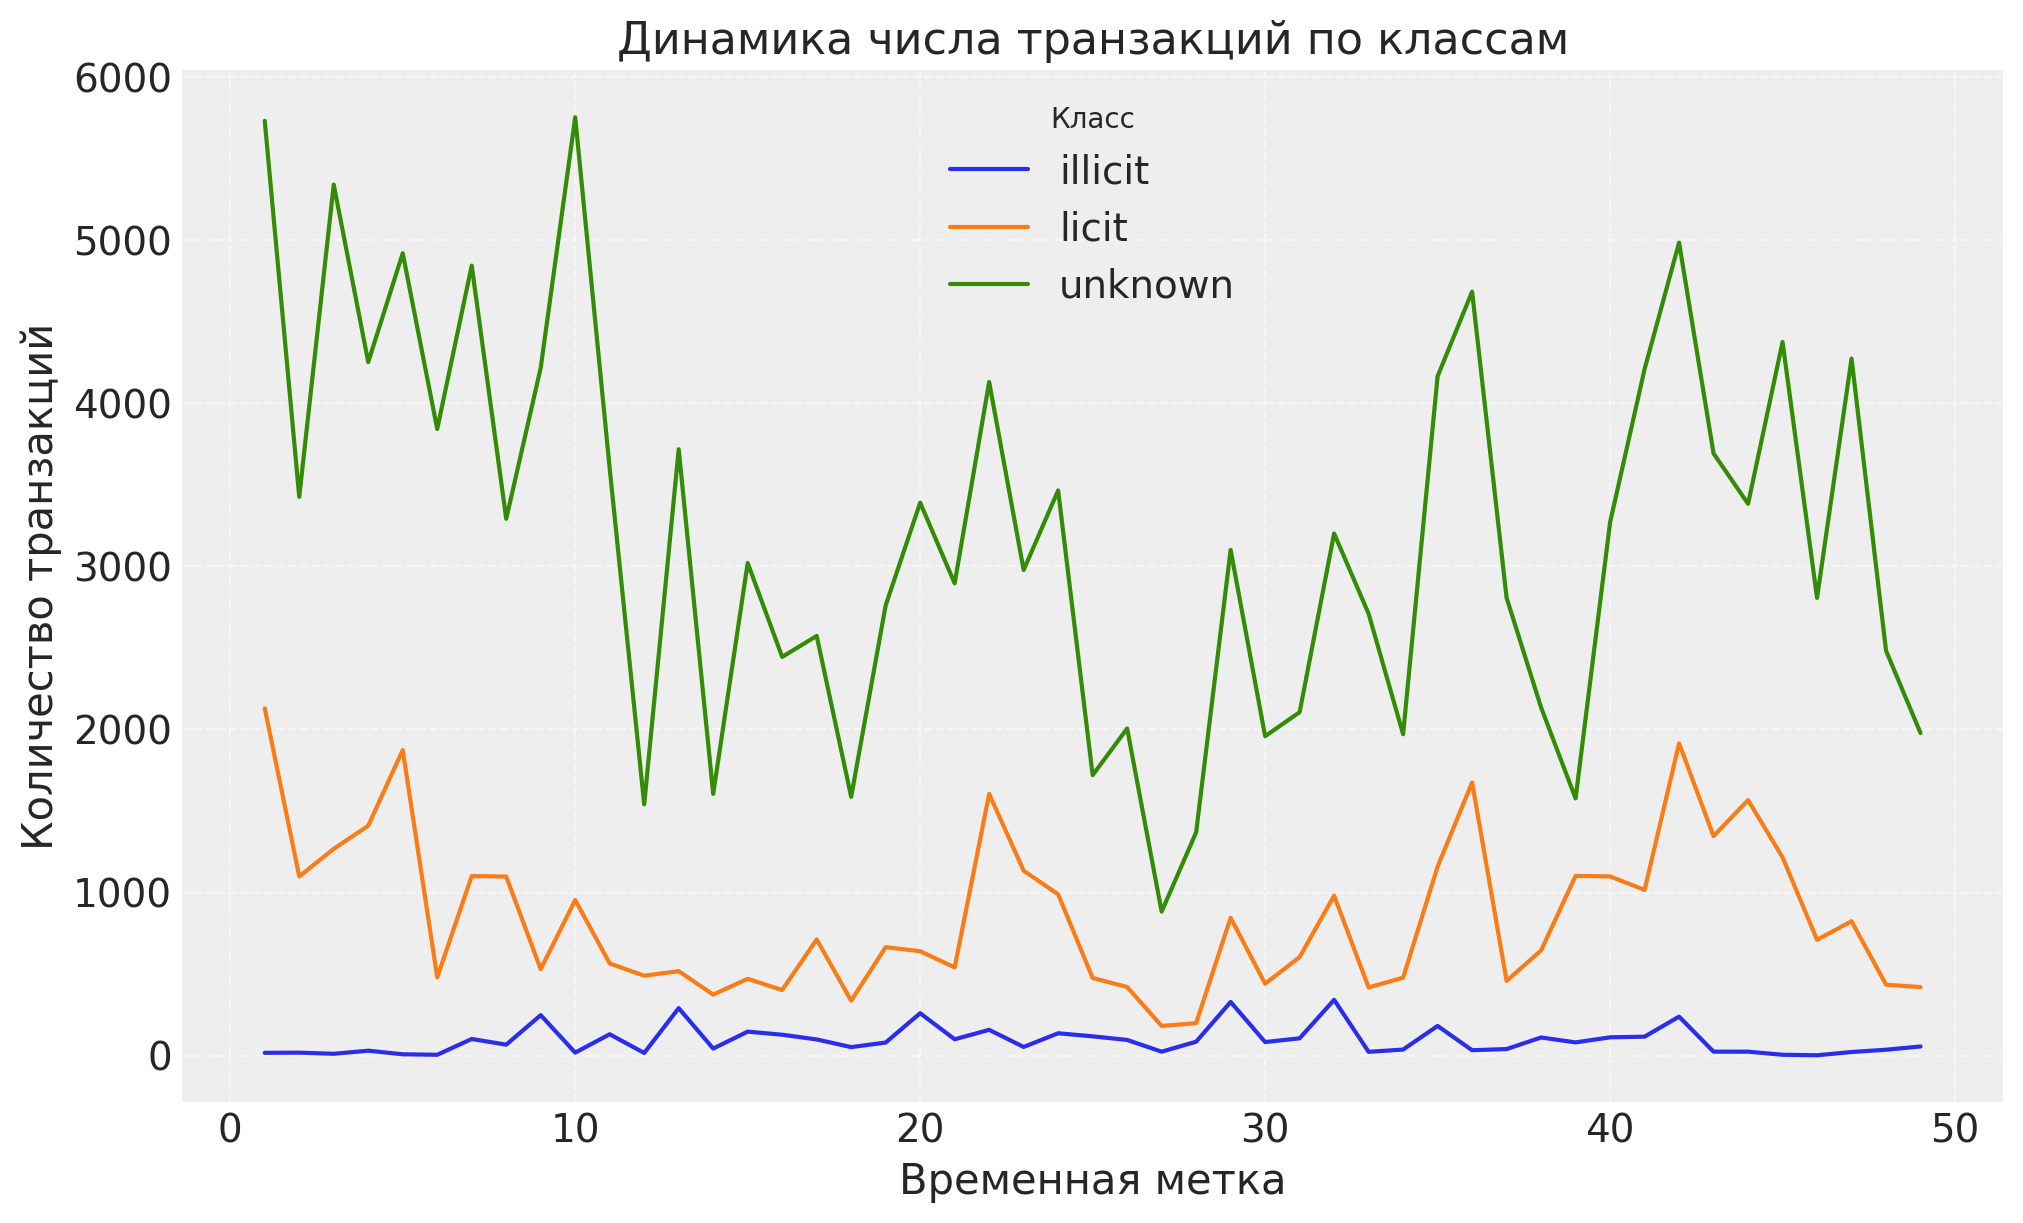

In [9]:
counts = df.groupby(['Time step', 'label_map']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
for lbl in counts.columns:
    plt.plot(counts.index, counts[lbl], label=lbl)
plt.xlabel('Временная метка')
plt.ylabel('Количество транзакций')
plt.title('Динамика числа транзакций по классам')
plt.legend(title='Класс')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Анализ данных. Акторы

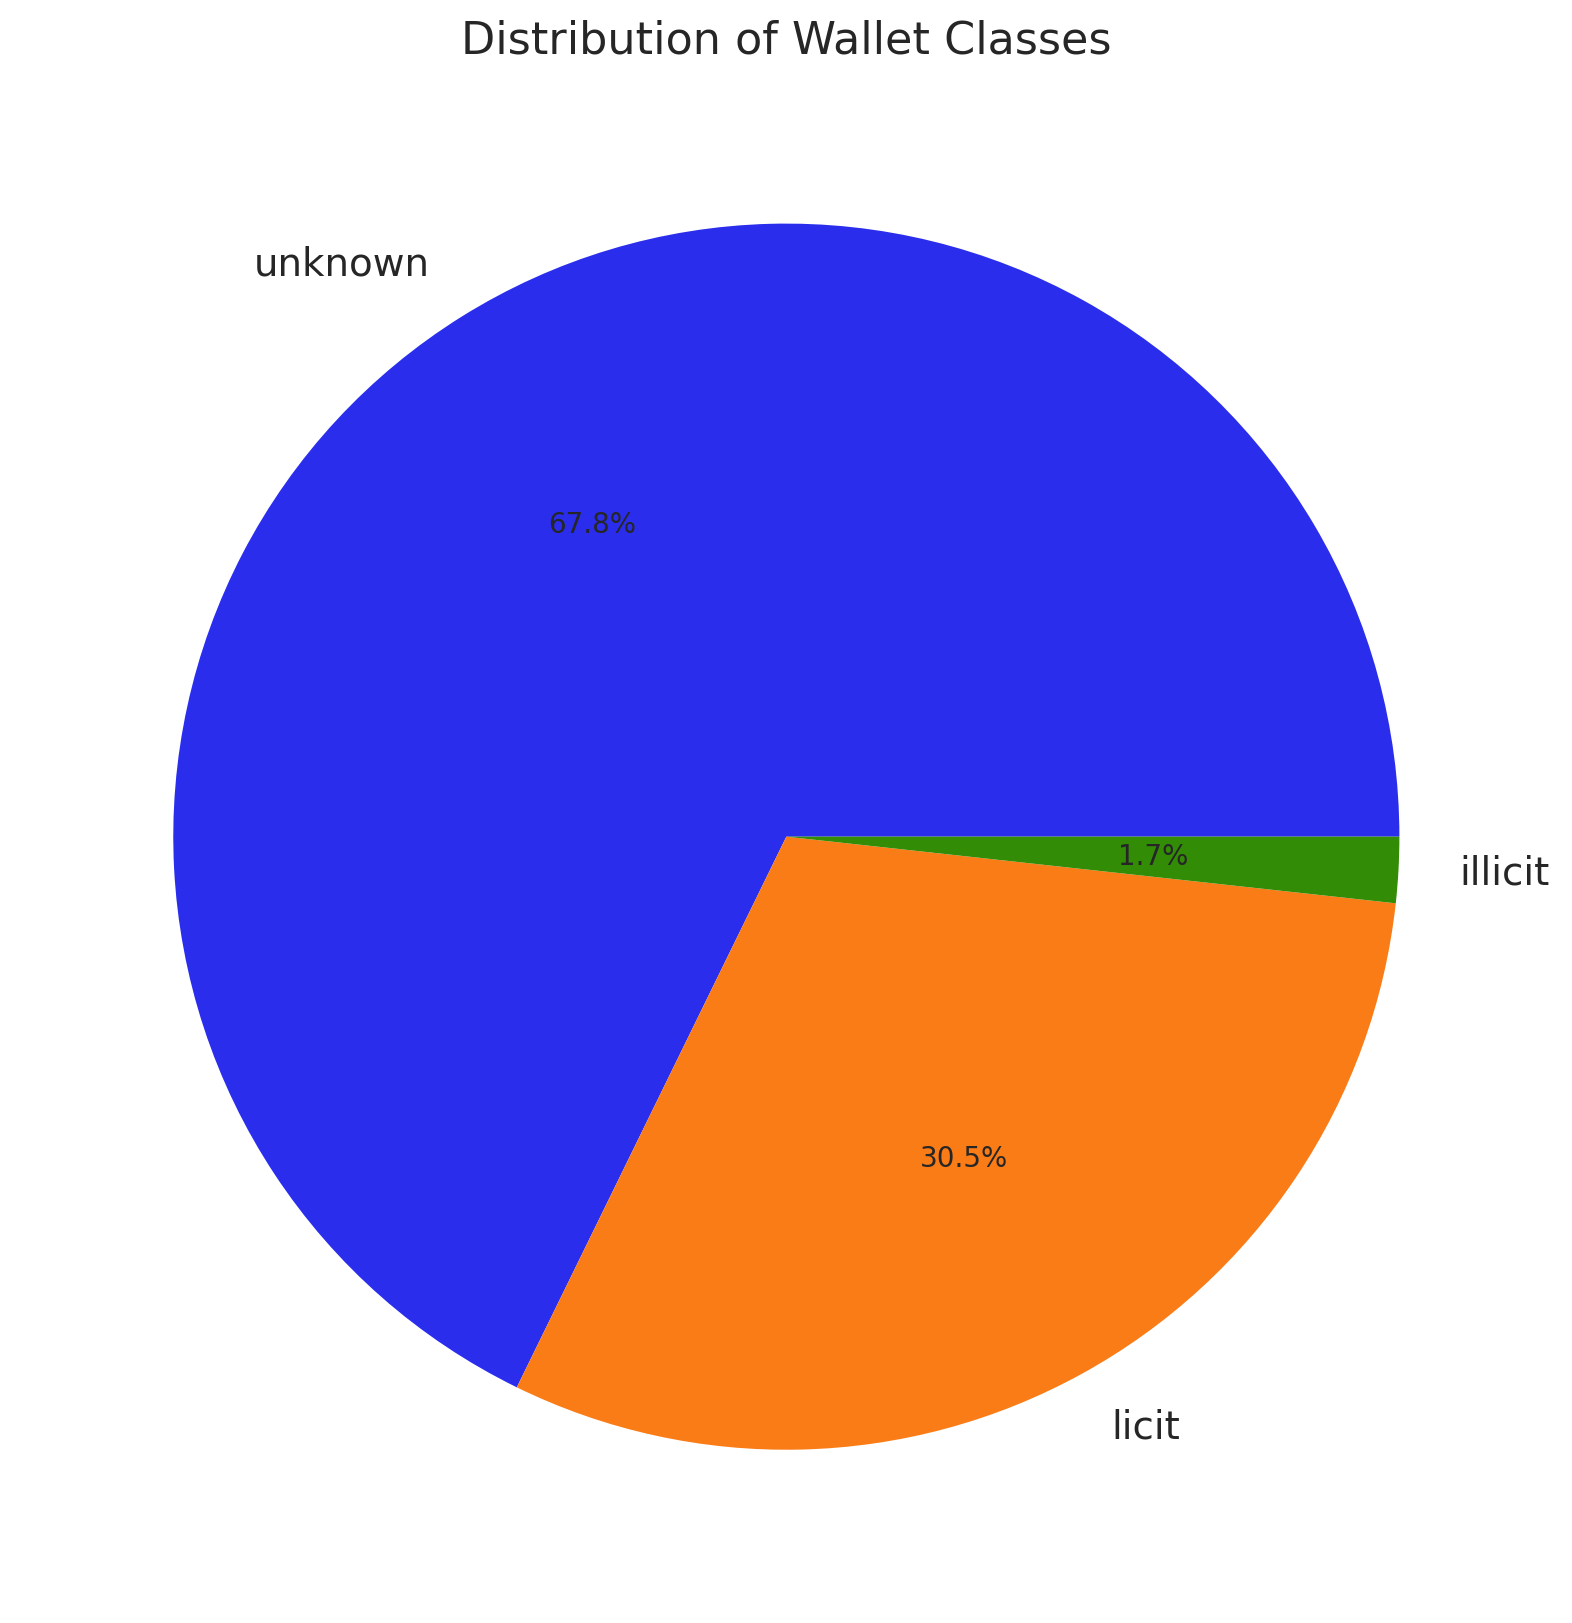

In [10]:
counts_w = df_wallets_classes['label_map'].value_counts()
plt.figure(figsize=(8, 8))
counts_w.plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Wallet Classes')
plt.ylabel('')
plt.show()